<a href="https://colab.research.google.com/github/tort-cam/ST-554-P1/blob/main/Task2/ST554Proj1EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Project 1 Task 2: Exploratory Data Analysis
Author : Cameron Mullaney

In this notebook, we will perform an **EDA** (exploratory data analysis) on the **Air Quality dataset** provided by UCI.

The purpose of an EDA is to make sure the data is cleaned, and to provide direction for future work with this dataset, ideally better informing which variables we would choose to investigate further.

This process features a few key steps:
1.  Loading in the data
2. Basic data validation
3. Investigate missing values
4. Clean up data (Handle missing values)
5. Investigate distributions

We will create some preliminary figures, and try to get a general idea of the patterns that may exist in this data. \
Our exploration revolves around the **Benzene levels** specifically, which dramatically reduces the number of relationships we have to explore. This  will heavily feature plots and single and multiple linear regression models.

## 1 - Loading in the data from UCI and installing modules I'll need.

This section is pretty straightforward - Because we are using a variety of methods to evaluate the data, we will need *quite a few* different modules.

In [171]:
!pip install ucimlrepo ## This module allows us to pull in the UCI data

In [172]:
## These will allow us to handle, visualize and analyze our data.
import numpy as np
import pandas as pd
import math
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn import linear_model
import sklearn.metrics as metrics
import plotly.express as px
from sklearn.model_selection import train_test_split

In [173]:
air_quality = fetch_ucirepo(id=360) #Pull in UCI data
aq = pd.DataFrame(air_quality.data.features)
#This air_quality object from UCI contains 2 separate datasets,
#and we only need one, the "features" subset.

###Understanding how this data is stored
This data is almost entirely numeric, with the exception of `Date` and `Time`, and we will convert those to a usable value later. All other columns are either integers or floats.

In [174]:
aq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


We were told we can ignore the "True" pollutant measurements, other than Benzene, so we're removing columns with a "(GT)" in them, other than C6H6 (Benzene)

In [175]:
aq_sub = aq.iloc[:,[0,1,3,5,6,8,10,11,12,13,14]] ## Keeping all rows, but only columns 0, 1, 3, etc.

Taking a look at aq_sub, it seems good! Removed what we don't need.

In [176]:
aq_sub

,Date,Time,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,1360,11.9,1046,1056,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,1292,9.4,955,1174,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,1402,9.0,939,1140,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,1376,9.2,948,1092,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1272,6.5,836,1205,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...
9352,4/4/2005,10:00:00,1314,13.5,1101,539,1374,1729,21.9,29.3,0.7568
9353,4/4/2005,11:00:00,1163,11.4,1027,604,1264,1269,24.3,23.7,0.7119
9354,4/4/2005,12:00:00,1142,12.4,1063,603,1241,1092,26.9,18.3,0.6406
9355,4/4/2005,13:00:00,1003,9.5,961,702,1041,770,28.3,13.5,0.5139


##2 - Basic Data Validation

Here, we want to take a look at the data and check for anything unusual, and try to resolve it.

Taking a quick peek at what we're working with using the `.describe()` method.
Looks like there are a lot of "-200"s, which represent "missing values"

In [177]:
aq_sub.describe()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,1048.990061,1.865683,894.595276,794.990168,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,329.832710,41.380206,342.333252,321.993552,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,921.000000,4.000000,711.000000,637.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1053.000000,7.900000,895.000000,794.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,1221.000000,13.600000,1105.000000,960.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,2040.000000,63.700000,2214.000000,2683.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


##3 - Investigate Missing Values

Let's see how many missing values there are: Looks like we've got ~3300, but only in 366 rows. This suggests that these missing values are often stacked in single rows. Here, `na_ct` will count missing values, while `row_ct` will count the number of rows containing missing values.

In [178]:
na_ct = 0 ## Count of missing values
row_ct = 0 ## Number of rows with >0 missing values
test = False ## Boolean for each row's status
for row in aq_sub.iloc[:,2:].values: ## Ignore "Date" and "Time" Columns
  test = False ## Reset to False every loop
  for val in row:
    if math.isclose(val, -200): ## Add 1 to na_ct for every "-200"
      na_ct+=1
      test = True ## If we find a missing value, this marks the row
  if test:
    row_ct+=1 ## After each row, if test == True, that row contains a missing value, so +1 to row count.
print ("Missing Values:\t",str(na_ct))
print ("Rows w/ Missing Values:\t", row_ct)

Missing Values:	 3294
Rows w/ Missing Values:	 366


##4 - Clean up data

It looks like we don't have any recourse to correct or fill in these missing values, so we're going to have to get rid of them.

Let's replace these -200 values with `NaN` values, and then we can use `.dropna()` to remove them. \
Our df has gotten 366 rows shorter, the number we were expecting from the last cell's `row_ct` value. The dateFrame has been renamed to `aqf` for "Air Quality Fixed".
We've also renamed our columns for clarity. Now, another look at `.describe()` shows us meaningful summaries of our data: We know each variables mean, median, st.dev and much more!

In [179]:
aqtemp = aq_sub.replace(float(-200), np.nan) ## Replace "-200" with "NaN"
aqf = aqtemp.dropna() ## Get rid of all rows with an "NaN"
print(len(aq_sub)-len(aqf))
aqf = aqf.rename(columns={'C6H6(GT)': 'B', 'PT08.S1(CO)': 'CO', \
                          'PT08.S2(NMHC)': 'NMHC', 'PT08.S3(NOx)': 'NOx', \
                          'PT08.S4(NO2)': 'NO2', 'PT08.S5(O3)': 'O3'})
aqf.describe()

366


,CO,B,NMHC,NOx,NO2,O3,T,RH,AH
count,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,1099.833166,10.083105,939.153376,835.493605,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,217.080037,7.449820,266.831429,256.817320,346.206794,398.484288,8.832116,17.316892,0.403813
min,647.000000,0.100000,383.000000,322.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,937.000000,4.400000,734.500000,658.000000,1227.000000,731.500000,11.800000,35.800000,0.736800
50%,1063.000000,8.200000,909.000000,806.000000,1463.000000,963.000000,17.800000,49.600000,0.995400
75%,1231.000000,14.000000,1116.000000,969.500000,1674.000000,1273.500000,24.400000,62.500000,1.313700
max,2040.000000,63.700000,2214.000000,2683.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


Here `date` and `time` are reformatted into a single column for simplicity, and we use `datetime` to treat them as a single datetime object.

In [180]:
aqf["DTtemp"] = aqf['Date'] + " " + aqf["Time"] ##New column which concatenates "Date" and "Time"
aqf["datetime"] = pd.to_datetime((aqf['DTtemp']), format = 'mixed', dayfirst = False)
aqf = aqf.drop("DTtemp", axis = 1)

##5 - Investigate Distributions

This section is the least concrete in its goals - We want to explore as many different aspects of this data as we can, to make sure we've considered any ways these variables could be related to **Benzene**

We'll produce *a lot* of graphs, as well as a lot of statistical summaries of the relationships between variables.

Now that we've cleaned up these missing values, let's get to work!

###Benzene Histogram

This basic histogram gives us some key info: Looks like Benzene (B) is pretty right skewed, with nearly all values being <20


Text(0, 0.5, '# of obs.')

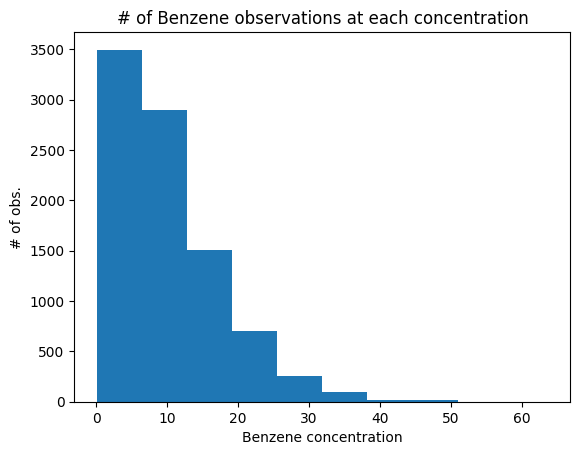

In [181]:
plt.hist(aqf["B"])
plt.title("# of Benzene observations at each concentration")
plt.xlabel("Benzene concentration")
plt.ylabel("# of obs.")

###Benzene by Datetime
Looks like the `datetime` column is working as intended! Noticing a drop in Benzene values around August 2004

Text(0, 0.5, 'Benzene Concentration')

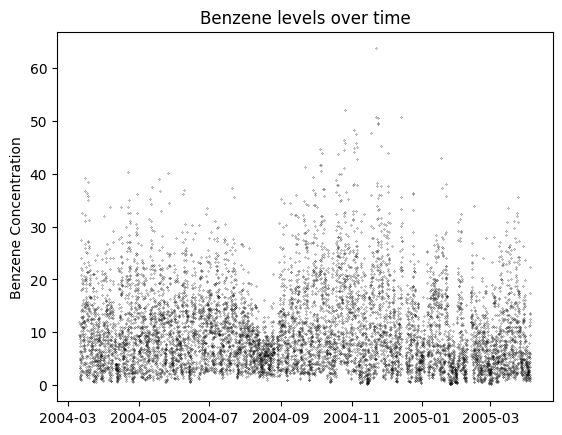

In [182]:
plt.scatter(aqf["datetime"], aqf["B"], s = .05, c = "black")
plt.title("Benzene levels over time")
plt.ylabel("Benzene Concentration")

###Benzene by Everything (W/ SLR)
Here we've got scatter plots of Benzene levels with every other numeric variable, just to get an idea of what our data looks like. Immediately, it seems like Benzene is correlated considerably with CO, NOx, NO2, and O3. NMHC looks a little *too* nice, where it seems like they might be measuring the same thing, just on different scales. We'll need some software math to figure out if temp, relative humidity, or absolute humidity are related to Benzene.

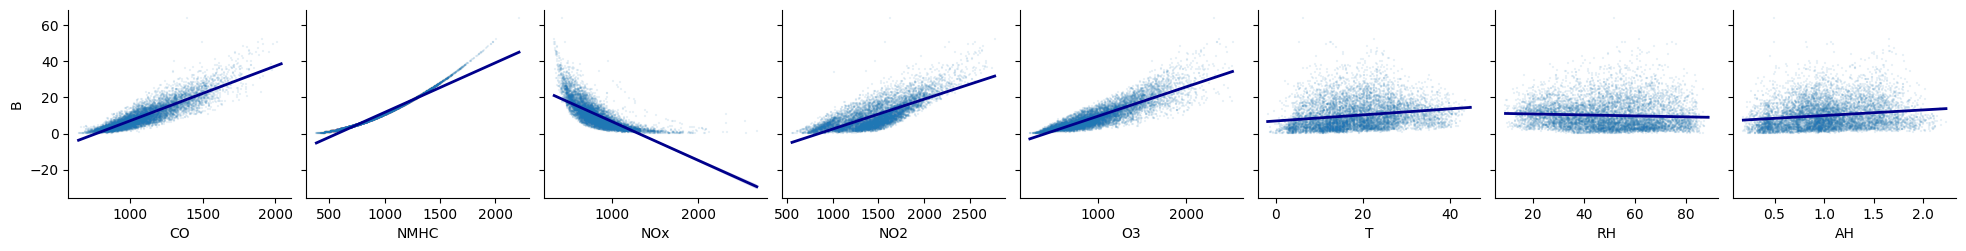

In [183]:
notB = aqf.columns.drop(["B", "Date", "Time", "datetime"])
every = sns.pairplot(kind = "reg", data = aqf, y_vars = "B", x_vars = notB, markers = "+",\
                    plot_kws = {'line_kws':{'lw' : 2, 'color':"darkblue"}, 'scatter_kws':{'alpha':.1, 's':2}})

###Datetime by Everything
Here, We've set the Y axis to `datetime`, showing changes in these variables over the 1 year range. Seems like a lot of the pollution variables drop in August 2004.

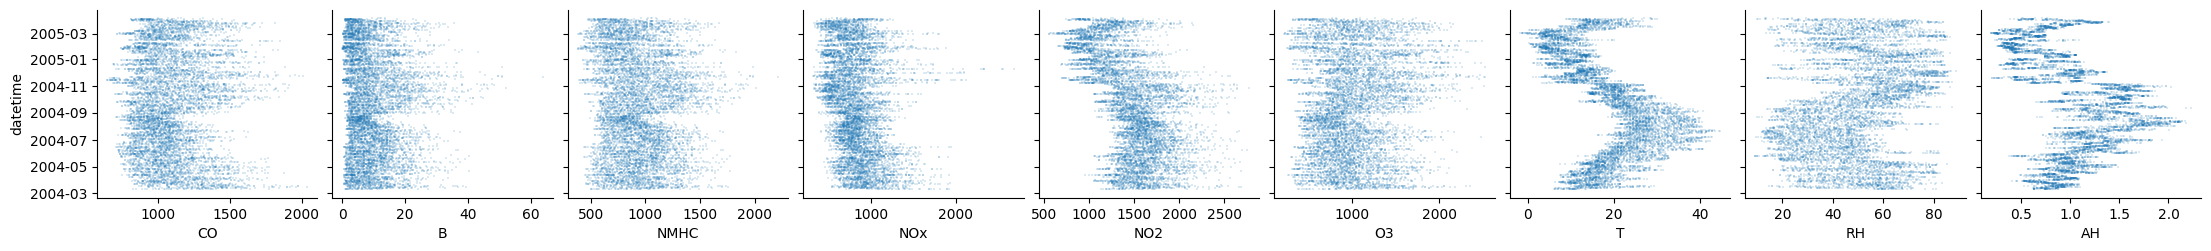

In [184]:
notDT = aqf.columns.drop(["Date", "Time", "datetime"]) ## List of columns to avoid in this set of plots
every = sns.pairplot(kind = "scatter", data = aqf, y_vars = "datetime", x_vars = notDT, markers = "+", plot_kws = {'s' : 2})

### SLR Models
Let's look at some linear model values!
Here we see that NMHC and Benzene are very strongly correlated (Rsquared of .965), which makes sense given their *too* nice graph earlier.

In [185]:
## First we must separate the data into a training and test set for RMSE evaluation
X_train, X_test, y_train, y_test = train_test_split(aqf['NMHC'], aqf['B'], test_size=0.2, random_state=42)
co = linear_model.LinearRegression()
co.fit(X_train.values.reshape(-1,1), y_train.values)
COpred = co.predict(X_test.values.reshape(-1,1))
print("Linear Model for NMHC and Benzene", "\nIntercept \t:", co.intercept_, "\nCoefficient\t:", co.coef_, \
      "\nRMSE\t\t:", np.sqrt(metrics.mean_squared_error(y_test.values, COpred)), "\nRsquared\t:", \
      co.score(X_test.values.reshape(-1,1), y_test))

Linear Model for NMHC and Benzene 
Intercept 	: -15.584768290053542 
Coefficient	: [0.02733408] 
RMSE		: 1.4147673534740177 
Rsquared	: 0.9651672288494462


The below function can be used to find some simple linear regression values more easily. Just need to provide the column names of the 2 variables, and `graph = True` if we want a visual.

In [186]:
def lmtest(v1, v2, graph = False):
  """
  This function takes in two column names from this data
  (NOT ANY DATA SHEET JUST THIS ONE)
  and returns some important regression values, as well as a color-coded figure.
  'graph = True' will provide a scatterplot with the SLR line of best fit
  """
  X_train, X_test, y_train, y_test = train_test_split(aqf[v1], aqf[v2], test_size=0.2, random_state=42) ## Separate out data into train and test sets

  lm = linear_model.LinearRegression()
  lm.fit(X_train.values.reshape(-1,1), y_train.values)
  if graph: ## If it's wanted, this will produce a best fit line for the data.
    sns.regplot(x = X_train, y = y_train, marker = "+", scatter_kws = {'s' : 1}, \
              line_kws ={'color': "darkblue"}, label = "Train")
    sns.scatterplot(x = X_test, y = y_test, marker = "o", s = 1, color = "red", label = "Test")
    plt.legend()
  pred = lm.predict(X_test.values.reshape(-1,1))
  print("Linear Model for " + v1 + " and " + v2, \
        "\nIntercept \t:", lm.intercept_, \
        "\nCoefficient\t:", lm.coef_, \
        "\nRMSE\t\t:", np.sqrt(metrics.mean_squared_error(y_test.values, pred)), \
        "\nRsquared\t:", lm.score(X_test.values.reshape(-1,1), y_test))

Here, this `lmtest` function is used to look at the relationship between NO2 and Benzene - The Rsquared value of .589 suggests a non-negligible relationship, with the difference in axis scale resulting in a very small coefficient.

Glad to see this function works, because it's about to get *a bunch* of use.

Linear Model for NO2 and B 
Intercept 	: -13.957832681811297 
Coefficient	: [0.0164713] 
RMSE		: 4.8582225009654545 
Rsquared	: 0.5892545423485874


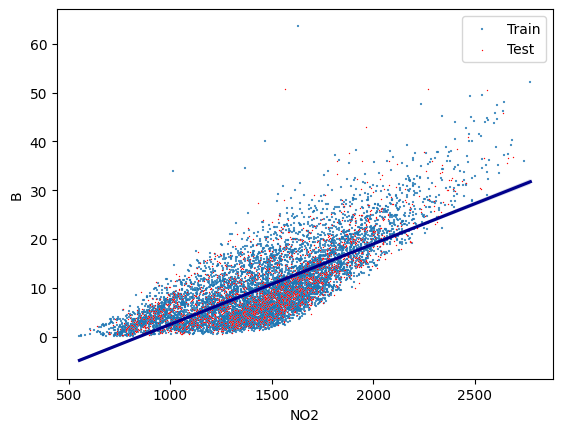

In [187]:
lmtest("NO2", "B", graph = True)

Now that this function works, we will use it to evaluate each possible SLR.
Here, RMSE will be very informative for comparing these results.

It's no surprise that NMHC has the smallest RMSE, but we also see that **CO** and **O3** both had RMSE's under 4, which when compared to our other models, suggests a pretty good fit!


In [188]:
notB = aqf.columns.drop(["Date", "Time", "datetime", "B"]) ## List of columns to avoid in these calculations
for x in notB:
  print(lmtest(x, "B"))
  print("\n----------------------------\n")

Linear Model for CO and B 
Intercept 	: -23.140510147421708 
Coefficient	: [0.03021024] 
RMSE		: 3.6131544704877157 
Rsquared	: 0.7728090512271075
None

----------------------------

Linear Model for NMHC and B 
Intercept 	: -15.584768290053542 
Coefficient	: [0.02733408] 
RMSE		: 1.4147673534740177 
Rsquared	: 0.9651672288494462
None

----------------------------

Linear Model for NOx and B 
Intercept 	: 27.651828810436122 
Coefficient	: [-0.02105204] 
RMSE		: 5.085795951328726 
Rsquared	: 0.549872205473908
None

----------------------------

Linear Model for NO2 and B 
Intercept 	: -13.957832681811297 
Coefficient	: [0.0164713] 
RMSE		: 4.8582225009654545 
Rsquared	: 0.5892545423485874
None

----------------------------

Linear Model for O3 and B 
Intercept 	: -6.388200630226013 
Coefficient	: [0.01610661] 
RMSE		: 3.7260644854489127 
Rsquared	: 0.7583878885274276
None

----------------------------

Linear Model for T and B 
Intercept 	: 7.014762021385534 
Coefficient	: [0.1624766] 


###MLR
This is a MLR of NOx, NO2, with Benzene. We get a RMSE of 3.86, which on it's own, doesn't mean much. More models to come.

In [189]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = \
  train_test_split(aqf['NOx'], aqf['NO2'], aqf['B'], \
                   test_size=0.2, random_state=42)

mlr = linear_model.LinearRegression()
# With two "x" variables, we must treat the data set a little differently:
# x1 and x2 are concatenated so they can be fed into the model as one object.
x_train = pd.concat([X1_train, X2_train], axis = 1)
x_test = pd.concat([X1_test, X2_test], axis = 1)
mlr.fit(x_train, y_train)
pred = mlr.predict(x_test)

print("Benzene by",X1_train.name, "and", X2_train.name, \
      "\nIntercept \t\t:", mlr.intercept_, \
      "\nCoefficient [NOx, NO2]\t:", mlr.coef_, \
      "\nRMSE\t\t\t:", np.sqrt(metrics.mean_squared_error(y_test.values, pred)), \
      "\nRsquared\t\t:", mlr.score(x_test, y_test))

Benzene by NOx and NO2 
Intercept 		: 4.597931721039066 
Coefficient [NOx, NO2]	: [-0.0130144   0.01121717] 
RMSE			: 3.8589592722962434 
Rsquared		: 0.7408457370244153


Just like before, placing the above cell's work into a function `mlrtest`, so I can test a lot of variables at once.

In [190]:
def mlrtest(v1, v2, RMSE = False):
  """
  This function takes in two column names from this data
  **NOT ANY DATA SHEET JUST THIS ONE**
  and returns some important regression values
  or just RMSE if you supply RMSE as True
  """
  X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(aqf[v1], aqf[v2], aqf['B'], test_size=0.2, random_state=42)
  mlr = linear_model.LinearRegression()
  x_train = pd.concat([X1_train, X2_train], axis = 1) ##With two "x" variables, we must treat the data set a little differently
  x_test = pd.concat([X1_test, X2_test], axis = 1)    ## Here we concatenate x1 and x2 together to can feed them into the model.
  mlr.fit(x_train, y_train) ## Fitting a model to our data
  pred = mlr.predict(x_test) ## Predicting Benzene levels based on the data

  if RMSE == False: ## General use print, similar to the SLR version
    print("Benzene by",v1, "and", v2, \
      "\nIntercept \t\t:", mlr.intercept_, \
      "\nCoefficient ["+v1+","+v2+"]\t:", mlr.coef_, \
      "\nRMSE\t\t\t:", np.sqrt(metrics.mean_squared_error(y_test.values, pred)), \
      "\nRsquared\t\t:", mlr.score(x_test, y_test))

  if RMSE: ##Specific use for the next cell, don't need all the data just RMSE
    print("Benzene by",v1, "and", v2, \
          "\nRMSE\t:", np.sqrt(metrics.mean_squared_error(y_test.values, pred)))

Here, we've put together a loop which runs an MLR test on every combination of our variables, with Benzene as the Y. This prints a pretty unwieldy amount of data, even with the new RMSE feature added to the function.

Anyhow, a quick "ctrl+f" shows us that our best two-variable combination to predict Benzene values is (NO2, O3). This model is the only one with an RMSE under 3.

Here, we also see that Temp and Relative Humidity give us a much larger RMSE of 7.40, suggesting that this model is not as helpful, and that these variables have less of an impact on Benzene day-to-day

In [191]:
notB = aqf.columns.drop(["Date", "Time", "datetime", "B", "NMHC"]) ## List of columns to avoid in these calculations
for v1 in notB: ## Choose v1 from notB's variable list
  notB2 = notB.drop(v1) ## Remove v1 from the list of options for v2
  for v2 in notB2: ## Choose v2 from the remainder of the list
    mlrtest(v1, v2, RMSE = True)
    print("----------------------------\t") ## Lines separating each print from mlrtest
  print("::::::::::::::::::::::::::::") ## Double lines marking when a new v1 is set.

Benzene by CO and NOx 
RMSE	: 3.5408212337224296
----------------------------	
Benzene by CO and NO2 
RMSE	: 3.2087158572926717
----------------------------	
Benzene by CO and O3 
RMSE	: 3.3180999706005667
----------------------------	
Benzene by CO and T 
RMSE	: 3.39559594177679
----------------------------	
Benzene by CO and RH 
RMSE	: 3.3350539928272673
----------------------------	
Benzene by CO and AH 
RMSE	: 3.6026353399217887
----------------------------	
::::::::::::::::::::::::::::
Benzene by NOx and CO 
RMSE	: 3.540821233722429
----------------------------	
Benzene by NOx and NO2 
RMSE	: 3.8589592722962434
----------------------------	
Benzene by NOx and O3 
RMSE	: 3.689646018339456
----------------------------	
Benzene by NOx and T 
RMSE	: 5.0171819604341135
----------------------------	
Benzene by NOx and RH 
RMSE	: 4.992942505051798
----------------------------	
Benzene by NOx and AH 
RMSE	: 5.085716620610324
----------------------------	
::::::::::::::::::::::::::::
Benze

This is a 3D *interactive* figure of O3, NO2, and Benzene, the same variables used in the MLR test above. Rotating this graph, it's pretty clear that these variables are related.

*This works in Colab, but not in the Github Preview.*

In [192]:
fig = plt.figure()
fig = px.scatter_3d(aqf, x = 'NO2', y = 'O3', z = 'B')
fig.update_traces(marker=dict(size=1))

<Figure size 640x480 with 0 Axes>

###Creating Categoricals

Because this dataset doesn't feature any categorical variables, it falls to us to create our own categories. From this data, there are a few variable that stand out as great candidates for a new categorical:
- **Datetime** &larr; could be days, months, seasons
- **Temperature(T)**, **Humidity(RH, AH)** &larr; could be on a scale (Low, Med, High)

Let's create some categories from these, and see how our Benzene data looks.

The `.describe()` method from earlier provides us with quartiles for our data, perfect for separating out these variables into comparative categories.

######Temperature

In [203]:
aqf['Tcat'] = "M"
aqf.loc[aqf['T']> 24.4, 'Tcat'] = "H" ##Top 25% of temps considered high
aqf.loc[aqf['T']< 11.8, 'Tcat'] = "L" ## Bottom 25% considered low
aqf['Tcat'] = aqf.Tcat.astype("category")
order = ["L", "M", "H"]
cat_dtype = pd.CategoricalDtype(categories=order, ordered=True)
aqf['Tcat'] = aqf['Tcat'].astype(cat_dtype) ## We will treat this "Tcat" column as a category

With a boxplot, we see that in general, as temp increases (From low -> medium -> high), mean Benzene level also increases. This is reflected in the numeric summary as well.

,B
Tcat,
L,7.837215
M,10.402320
H,11.682706


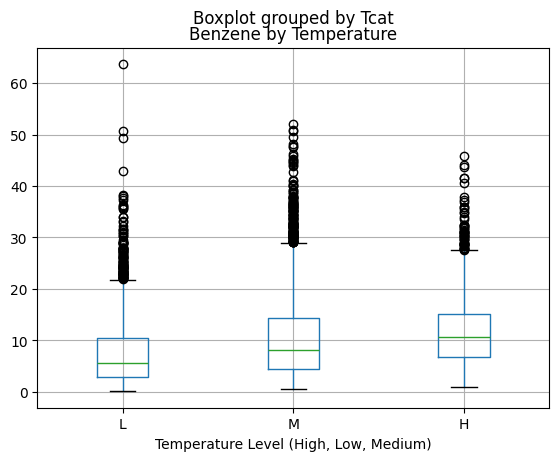

In [206]:
aqf.boxplot(column = ['B'], by = "Tcat")
plt.title("Benzene by Temperature")
plt.xlabel("Temperature Level (High, Low, Medium)")

aqf.groupby("Tcat", observed = False)["B"].mean() ## Prints a table of mean B at each Tcat

##### Relative Humidity

In [207]:
aqf['RHcat'] = "M"
aqf.loc[aqf['RH']> 62.5, 'RHcat'] = "H" ##Same as for temperature
aqf.loc[aqf['RH']< 35.8, 'RHcat'] = "L"
aqf['RHcat'] = aqf.RHcat.astype("category")
aqf['RHcat'] = aqf['RHcat'].astype(cat_dtype)

We don't see nearly as much change as Relative Humidity increases, though there is still a slight change.

,B
RHcat,
L,10.803084
M,10.056390
H,9.417642


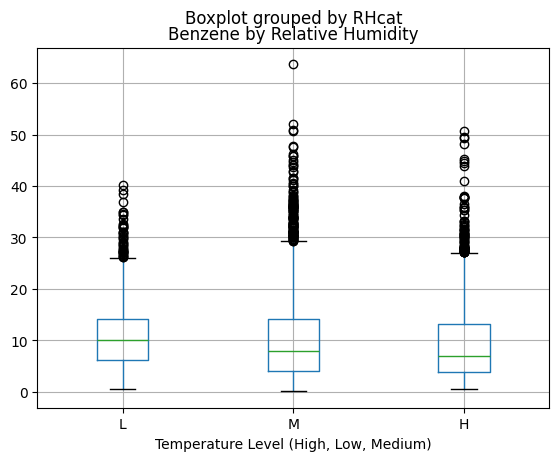

In [208]:
aqf.boxplot(column = ['B'], by = "RHcat")
plt.title("Benzene by Relative Humidity")
plt.xlabel("Temperature Level (High, Low, Medium)")
aqf.groupby("RHcat", observed = False)["B"].mean()

#####Months and Seasons

In [209]:
aqf['Month'] = pd.DatetimeIndex(aqf['datetime']).month
cat_dtype2 = pd.CategoricalDtype(ordered=True)
aqf['Month'] = aqf['Month'].astype(cat_dtype2)
##This column is numbers, but we are treating it as an ordered category
##Don't want to accidentally treat months as numbers (add, subtract, etc.)

In [210]:
aqf["Season"] = "Fall" ## All months get "fall"
aqf.loc[aqf['Month']< 10,'Season'] = "Summer"## If month is before october, it gets "summer"
aqf.loc[aqf['Month']< 7, 'Season'] = "Spring"## We go down the list editing only the earlier months
aqf.loc[aqf['Month']< 4, 'Season'] = "Winter"## until they're all categorized.
aqf['Season'] = aqf.Season.astype("category")
order2 = ["Winter", "Spring", "Summer", "Fall"] ## Set the month order for plotting
cat_dtype = pd.CategoricalDtype(categories=order2, ordered=True)
aqf['Season'] = aqf['Season'].astype(cat_dtype)

We do see some seasonal and monthly variation in Benzene!

<Axes: title={'center': 'B'}, xlabel='Season'>

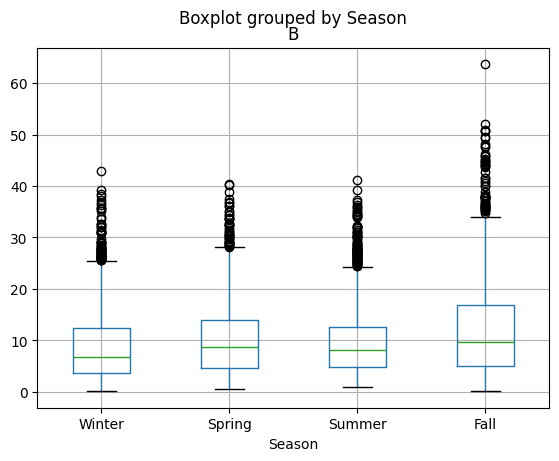

In [211]:
aqf.boxplot(column = ['B'], by = "Season")

<Axes: title={'center': 'B'}, xlabel='Month', ylabel='B'>

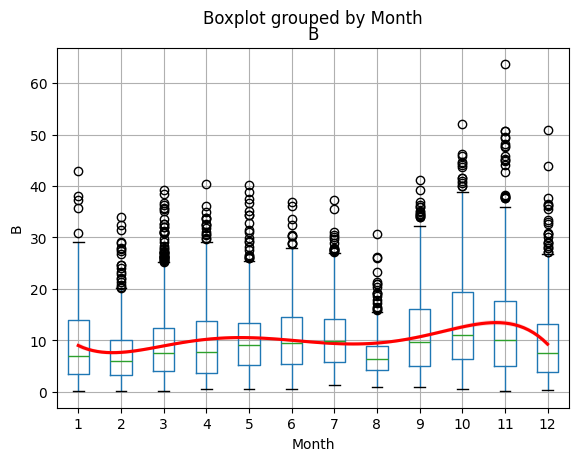

In [215]:
aqf.boxplot(column = ['B'], by = "Month")
sns.regplot(x = aqf['Month'], y = aqf['B'], order = 5, marker = "none", color = "red")

### Correlations

Here we've printed the Spearman's correlation values for Benzene with each other numeric variable (no dates or times). What we see here reflects the figures in **Benzene by Everything**, where the other pollutants are much more clearly correlated with Benzene than temperature or humidity.

In [201]:
notB = aqf.columns.drop(["B", "Date", "Time", "datetime", "Tcat", "RHcat", "Month", "Season"])
print("Spearman's Corr Values \n")
for x in notB:
  print(x, "\n", aqf.loc[:, ["B", x]].corr(method = 'spearman'), "\n")


Spearman's Corr Values 

CO 
           B       CO
B   1.00000  0.88948
CO  0.88948  1.00000 

NMHC 
              B      NMHC
B     1.000000  0.999984
NMHC  0.999984  1.000000 

NOx 
            B      NOx
B    1.00000 -0.85036
NOx -0.85036  1.00000 

NO2 
             B       NO2
B    1.000000  0.748551
NO2  0.748551  1.000000 

O3 
            B        O3
B   1.000000  0.873823
O3  0.873823  1.000000 

T 
          B        T
B  1.00000  0.27565
T  0.27565  1.00000 

RH 
            B        RH
B   1.000000 -0.122272
RH -0.122272  1.000000 

AH 
            B        AH
B   1.000000  0.191749
AH  0.191749  1.000000 



##Conclusion

This was a very productive EDA! We looked at this data through a variety of different lenses, and found some specific variables and features that seem strongly correlated with changes in Benzene concentrations! To recap:

* There were quite a few missing values, and they were easy to remove.
* If we only use one "predictor" variable, `CO` and `O3` were our best predictors.
* If we take two "predictors", using `NO2` and `O3` together gave us the most accurate model.
* We did see monthly/seasonal variation in Benzene
* Benzene did seem to vary over temperature categories, though this and the seasonal variation is likely related

We come out of this with a good idea of which variables are most related to benzene, and what relationships may be worth a closer look!